## Construção de Modelos Simples com Vetorização TF-IDF de <i>Features</i>

Neste notebook serão construídos 4 modelos simples com diferentes aproximações algorítmicas (Florestas Aleatórias, Regressão Logística, Naive Bayes e SVM) utilizando vetorização TF-IDF para a estruturação dos arrays de <i>features</i>. O modelo que apresentar melhor resultado no conjunto de validação será salvo no drive para ser comparado com o modelo desenvolvido no final do trabalho.

In [61]:
from google.colab import drive
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import json
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# read the train and validation datasets
documents = pd.read_csv('/content/drive/My Drive/MAC499 - Kaique e Yurick/DB/Train_Dataset.csv')
val_documents = pd.read_csv('/content/drive/My Drive/MAC499 - Kaique e Yurick/DB/Validation_Dataset.csv')

In [6]:
# load the keywords from the JSON file
with open('/content/drive/My Drive/MAC499 - Kaique e Yurick/DB/keywords.json') as keywords_file:
  keywords = json.load(keywords_file)

In [8]:
# build vocabulary object from keywords file
vocabulary = {}
i = 0
for branch in keywords:
  for word in keywords[branch]:
    if word not in vocabulary:
      vocabulary[word] = i
      i = i + 1

In [9]:
# extract the labels and the annotations from the datasets and put them in simple lists
train_content = []
val_content = []
train_labels = []
val_labels = []
for row in documents.iterrows():
  train_content.append(row[1][5])
  train_labels.append(row[1][2])
for row in val_documents.iterrows():
  val_content.append(row[1][5])
  val_labels.append(row[1][2])

In [10]:
# creates a TF-IDF vectorizer with the built vocabulary 
transformer = TfidfVectorizer(vocabulary=vocabulary)

In [11]:
# transforms the training and validation data into array of features
train_features = transformer.fit_transform(train_content).toarray()
val_features = transformer.transform(val_content).toarray()

In [14]:
# create the various types of models and pass the training features as input
svModel = LinearSVC()
rfModel = RandomForestClassifier()
nbModel = MultinomialNB()
lrModel = LogisticRegression()

svModel.fit(train_features, train_labels)
rfModel.fit(train_features, train_labels)
nbModel.fit(train_features, train_labels)
lrModel.fit(train_features, train_labels)

LogisticRegression()

In [29]:
# score the models in the validation data
scores = [
          {'Model': 'Support Vector', 'Score': svModel.predict(val_features)},
          {'Model': 'Random Forest', 'Score': rfModel.predict(val_features)},
          {'Model': 'Naive Bayes', 'Score': nbModel.predict(val_features)},
          {'Model': 'Logistic Regression', 'Score': lrModel.predict(val_features)}
]

In [30]:
# calculate the metrics for all models
metrics = []
for score in scores:
  metrics.append({
      'name': score['Model'], 
      'metrics': {
        "Average Accuracy": accuracy_score(val_labels, score['Score']),
        "Weighted Precision": precision_score(val_labels, score['Score'], average='weighted'),
        "Weighted Recall": recall_score(val_labels, score['Score'], average='weighted'),
        "Weighted F1 Score": f1_score(val_labels, score['Score'], average='weighted'),
        "Balanced Accuracy": balanced_accuracy_score(val_labels, score['Score']),
        "Cohen Kappa Score": cohen_kappa_score(val_labels, score['Score']),
        "Matthews Correlation Coefficient": matthews_corrcoef(val_labels, score['Score'])
      }
  })

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

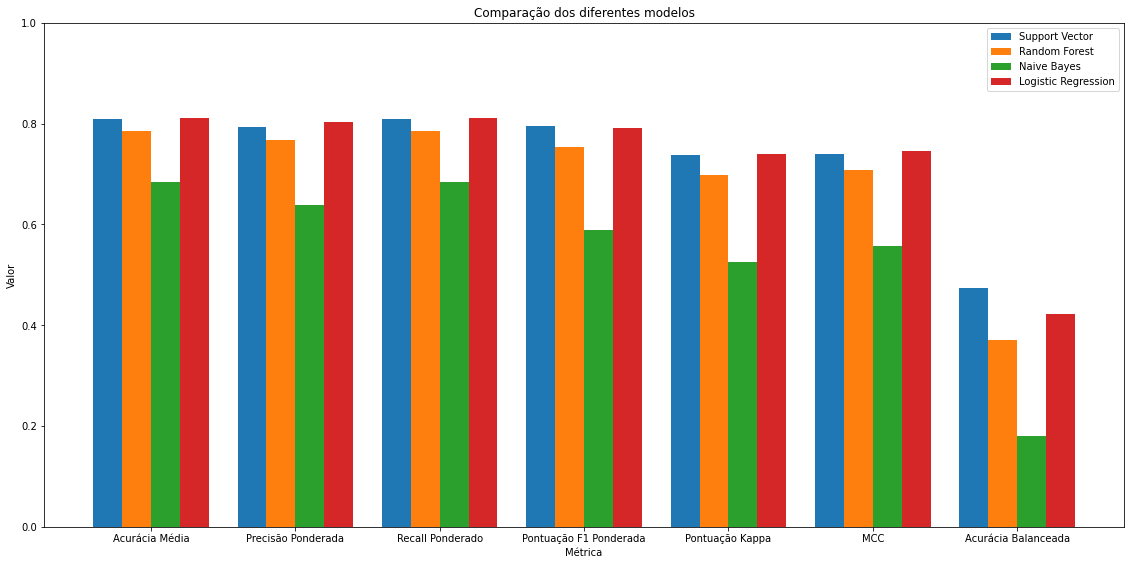

In [56]:
# plot a chart for visualization and saves the "best" model for each metric
fig = plt.figure(figsize=(15,7))
ax = fig.add_axes([0,0,1,1])
greater_metrics = {}
models = []
best = []
x = ['Acurácia Média', 'Precisão Ponderada', 'Recall Ponderada', 'Pontuação F1 Ponderada', 'Acurácia Balanceada', 'Pontuação Kappa', 'MCC']
x2 = ['Average Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1 Score', 'Cohen Kappa Score', 'Matthews Correlation Coefficient', 'Balanced Accuracy']
X = np.arange(7)
i = 0
for metric in metrics:
  y = []
  models.append(metric['name'])
  for id, e in enumerate(x2):
    y.append(metric['metrics'][e])
    if e in greater_metrics:
      if metric['metrics'][e] > greater_metrics[e]:
        greater_metrics[e] = metric['metrics'][e]
        best[id] = metric['name']
    else:
      greater_metrics[e] = metric['metrics'][e]
      best.append(metric['name'])
  ax.bar(X + i, y, width=0.2)
  i = i + 0.2
ax.set_title('Comparação dos diferentes modelos')
ax.set_ylim(top=1)
ax.set_xticks([.3, 1.3, 2.3, 3.3, 4.3, 5.3, 6.3])
ax.set_xticklabels(['Acurácia Média', 'Precisão Ponderada', 'Recall Ponderado', 'Pontuação F1 Ponderada', 'Pontuação Kappa', 'MCC', 'Acurácia Balanceada'])
ax.legend(models)
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.show()

In [59]:
# get the model with most occurences in "best" metrics list
best

['Logistic Regression',
 'Logistic Regression',
 'Logistic Regression',
 'Support Vector',
 'Logistic Regression',
 'Logistic Regression',
 'Support Vector']

In [60]:
# persists the choosen model, which is the Logistic Regression one
pickle.dump(lrModel, open('/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/saved_models/lr_model.sav', 'wb'))